In [17]:
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt  
%matplotlib inline
from ocr.helpers import implt, resize, ratio
from ocr.page_detection import edges_det, four_corners_sort, contour_offset, find_page_contours, persp_transform

In [18]:
num_q=40
np.random.seed(5)
ANSWER_KEY={}
for i in range(40):
    ANSWER_KEY[i]="NA"
ans=np.random.randint(low=0, high=4, size=num_q)
FILLED_ANSWERS=[]
for i in range(0,num_q):
    FILLED_ANSWERS.append(ans[i])  

In [19]:
print(FILLED_ANSWERS)

[3, 2, 3, 1, 2, 2, 0, 1, 0, 0, 3, 2, 3, 0, 2, 0, 3, 0, 3, 1, 1, 3, 0, 3, 0, 1, 3, 1, 3, 2, 0, 2, 1, 2, 2, 1, 1, 2, 1, 1]


In [20]:
ACTUAL_ANSWERS=[]
for i in range(len(FILLED_ANSWERS)):
    if(i%2==0):
        ACTUAL_ANSWERS.append(FILLED_ANSWERS[i])
for i in range(len(FILLED_ANSWERS)):
    if(i%2==1):
        ACTUAL_ANSWERS.append(FILLED_ANSWERS[i])

In [21]:
for i in range(len(ACTUAL_ANSWERS)):
    ANSWER_KEY[i]=ACTUAL_ANSWERS[i]

In [22]:
ANSWER_KEY[0]=1
ANSWER_KEY[2]=2
ANSWER_KEY[4]=1
ANSWER_KEY[6]=1
ANSWER_KEY[8]=2
ANSWER_KEY[10]=2
ANSWER_KEY[12]=1

In [23]:
print(ANSWER_KEY)

{0: 1, 1: 3, 2: 2, 3: 0, 4: 1, 5: 3, 6: 1, 7: 2, 8: 2, 9: 3, 10: 2, 11: 0, 12: 1, 13: 3, 14: 3, 15: 0, 16: 1, 17: 2, 18: 1, 19: 1, 20: 2, 21: 1, 22: 2, 23: 1, 24: 0, 25: 2, 26: 0, 27: 0, 28: 0, 29: 1, 30: 3, 31: 3, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 1, 38: 2, 39: 1}


In [24]:
import glob
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob(r'C:\Users\Gautam\Desktop\OMR\IMAGES\*jpeg')]

In [9]:
len(images)

4

In [10]:
def remove_shadows(gray_scale):
    rgb_planes=cv2.split(gray_scale)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img=np.ones(shape=diff_img.shape)
        norm_img=cv2.normalize(diff_img,norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
    result = cv2.merge(result_planes)
    return cv2.merge(result_norm_planes)


In [11]:
def get_answers(questionCnts, thresh, ANSWER_KEY, ans_array, paper):
    for (q, i) in enumerate(np.arange(0, len(questionCnts), 4)):
        

        cnts = contours.sort_contours(questionCnts[i:i + 4])[0]
        bubbled = None
        flag=False

        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)


            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if (flag and total>220):
                bubbled=None
                break
            if(total>220):
                flag=True

            if(total>220):
                bubbled=(total,j)

        color = (0, 0, 255)
        k = ANSWER_KEY[q]

        if bubbled and k == bubbled[1]:
            color = (0, 255, 0)
            
            ans_array.append(k)       
        elif not bubbled:
            ans_array.append("NA")
        elif bubbled and k!=bubbled[1]:
            ans_array.append(bubbled[1])  

        cv2.drawContours(paper, [cnts[k]], -1, color, 3)
    return ans_array

In [12]:
def get_roll_number(ROLL_NO, thresh):
    roll=[]
    count=-1;
    idx=0
    for i in range(0,60, 10):
        count+=1;
        cnts = contours.sort_contours(ROLL_NO[i:i + 10])[0]
        bubbled = None
        flag=False
        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)

            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if (flag and total>220):
                bubbled=None
                break
            if(total>220):
                flag=True
            if(total>220):
                bubbled=(total,j)
            color = (0, 255, 255)
            if(bubbled):
                roll.append(j)
                break
    return roll

In [13]:
def find_questions(thresh, paper):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    questionCnts = []
    tester=cv2.drawContours(paper.copy(), cnts, -1, (255,0,0), 2)

    for c in cnts:

        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)

        if ((w >= 17 and h >=17) and (w<=23 and h<=23) and ar >= 0.85 and ar <= 1.15):
            questionCnts.append(c)
    return questionCnts

In [14]:
def evaluate_image_batch(images, ANSWER_KEY):
    d=0
    for image in images:
        d+=1
        print(d, "out of" ,len(images), "processed")
        ans_array=[]
        ## image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        edged=edges_det(image,200,250)
        edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, np.ones((5, 11)))
        conts=find_page_contours(edged, resize(image))
        contoured=cv2.drawContours(resize(image.copy()), [conts], -1, (0, 255, 0), 3)
        conts=conts.dot(ratio(image))
        if(conts[0][0]==0):
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\pagenotdetected_%d.jpg"%d, np.zeros(shape=(500,500)))
            print(d, "***")
            continue
        paper = persp_transform(image, conts)
        warped = persp_transform(gray, conts)
        warped=resize(warped)
        paper=resize(paper)
        warped=remove_shadows(warped)
        thresh = cv2.threshold(warped.copy(), 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        questionCnts=find_questions(thresh,paper)
        if(len(questionCnts)!=220):
            print(d, "***")
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dquestion_not_detected.jpg"%d, np.zeros(shape=(500,500)))
            continue
        AllCircles = imutils.contours.sort_contours(questionCnts, method="top-to-bottom")[0]
        correct = 0
        ROLL_NO=AllCircles[0:60]
        questionCnts=AllCircles[60:]
        if(len(ROLL_NO)!=60 or len(questionCnts)!=160):
            print(d)
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dquestion_not_detected.jpg"%d, np.zeros(shape=(500,500)))
            continue
        cv2.drawContours(paper, ROLL_NO, -1, (255,0,100), 3)
        try:
            answers=get_answers(questionCnts, thresh, ANSWER_KEY, ans_array, paper)
        except:
            print(d, "***")
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%derror_get_answers.jpg"%d, np.zeros(shape=(500,500)))
            continue
        try:
            get_roll_number(ROLL_NO, thresh)
        except:
            print(d, "***")
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%derror_get_rolls.jpg"%d, np.zeros(shape=(500,500)))
            continue
        cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dresult.jpg"%d, paper)      

In [15]:
evaluate_image_batch(images, ANSWER_KEY)

1 out of 4 processed
2 out of 4 processed
3 out of 4 processed
4 out of 4 processed


In [226]:
image = cv2.cvtColor(cv2.imread(r"C:\Users\Gautam\Desktop\OMR\IMAGES\im3.jpg"), cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged=edges_det(image, 200, 250)

In [227]:
##cv2.imwrite("image.jpg", image)
##cv2.imwrite("gray.jpg", gray)
##cv2.imwrite("blurred.jpg", blurred)
##cv2.imwrite("edged.jpg", edged)
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, np.ones((5, 11))) ## closing operation after finding edges close the gaps

In [228]:
cv2.imwrite("edgedn.jpg", edged)

True

In [229]:
conts=find_page_contours(edged, resize(image))

In [230]:
contoured=cv2.drawContours(resize(image.copy()), [conts], -1, (0, 255, 0), 3)

In [231]:
cv2.imwrite("11contouredn.jpg", contoured)

True

In [232]:
conts

array([[ 14,  89],
       [ 13, 672],
       [431, 660],
       [416,  83]], dtype=int32)

In [233]:
conts=conts.dot(ratio(image))

In [234]:
cv2.imwrite("5contoured.jpg", contoured)

True

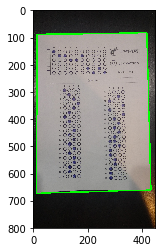

In [235]:
implt(contoured)

In [236]:
paper = persp_transform(image, conts)
warped = persp_transform(gray, conts)
warped.shape

(2915, 2090)

## EXPERIMENTAL LINE

In [237]:
##  cnts = cv2.findContours(warped.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
## cv2.drawContours(warped, cnts, -1, (0,255,0), 3)

In [238]:
cv2.imwrite("6paper.jpg", paper)
cv2.imwrite("7warped.jpg", warped)
warped=resize(warped)
paper=resize(paper)

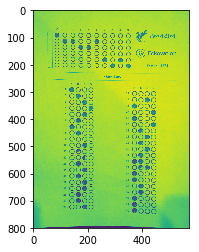

In [239]:
implt(warped)

In [240]:
def remove_shadows(gray_scale):
    rgb_planes=cv2.split(gray_scale)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img=np.ones(shape=diff_img.shape)
        norm_img=cv2.normalize(diff_img,norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
    result = cv2.merge(result_planes)
    return cv2.merge(result_norm_planes)



In [241]:
warped=remove_shadows(warped)

In [242]:
thresh = cv2.threshold(warped, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [243]:
thresh.shape

(800, 573)

In [244]:
cv2.imwrite("8thresh.jpg", thresh)

True

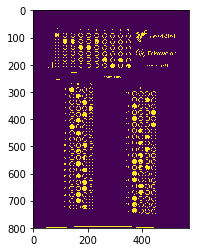

In [245]:
implt(thresh)

In [246]:
def find_questions(thresh, paper):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    questionCnts = []
    tester=cv2.drawContours(paper.copy(), cnts, -1, (255,0,0), 2)

    for c in cnts:

        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        
        if ((w >= 17 and h >=17) and (w<=23 and h<=23) and ar >= 0.85 and ar <= 1.15):
            questionCnts.append(c)
    return questionCnts

In [247]:
questionCnts=find_questions(thresh, paper)
AllCircles = imutils.contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0
minm = []
maxm = []
##ans_array=[]
##roll=[]

In [248]:
print(len(AllCircles))

220


In [249]:
ROLL_NO=AllCircles[0:60]
questionCnts=AllCircles[60:]

In [250]:
print(len(ROLL_NO))
print(len(questionCnts))
if(len(ROLL_NO)!=60):
    raise Exception("All Roll numbers not recognised, please take pic again")
if(len(questionCnts)!=160):
    raise Exception("All questions not recognised, please take pic again")

60
160


In [251]:
cv2.drawContours(paper, ROLL_NO, -1, (255,0,100), 3)
cv2.imwrite("12rolls.jpg", paper)

True

## DEBUGGING CELL

for (q, i) in enumerate(np.arange(0, len(questionCnts), 4)):
	count+=1
	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 4])[0]
	bubbled = None
	flag=False
	# loop over the sorted contours
	for (j, c) in enumerate(cnts):
		# construct a mask that reveals only the current
		# "bubble" for the question
		mask = np.zeros(thresh.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)

		# apply the mask to the thresholded image, then
		# count the number of non-zero pixels in the
		# bubble area
		mask = cv2.bitwise_and(thresh, thresh, mask=mask)
		total = cv2.countNonZero(mask)

		minm.append(total)
          
		# if the current total has a larger number of total
		# non-zero pixels, then we are examining the currently
		# bubbled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j) # What ???
	maxm.append(bubbled[0])
	# initialize the contour color and the index of the
	# *correct* answer
	color = (0, 0, 255)
	k = ANSWER_KEY[q]
	if k == bubbled[1]:
			color = (0, 255, 0)
			correct += 1        
	# check to see if the bubbled answer is correct 
	# draw the outline of the correct answer on the test
	cv2.drawContours(paper, [cnts[k]], -1, color, 3)

print(minm)
for o in minm:
    maxm.remove(o)
print(maxm)


In [252]:
def get_answers(questionsCnts, thresh, ANSWER_KEY, ans_array):
    for (q, i) in enumerate(np.arange(0, len(questionCnts), 4)):
        print(q,i)

        cnts = contours.sort_contours(questionCnts[i:i + 4])[0]
        bubbled = None
        flag=False

        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)


            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if (flag and total>220):
                bubbled=None
                break
            if(total>220):
                flag=True

            if(total>220):
                bubbled=(total,j)

        color = (0, 0, 255)
        k = ANSWER_KEY[q]

        if bubbled and k == bubbled[1]:
            color = (0, 255, 0)
            ans_array.append(k)       
        elif not bubbled:
            ans_array.append("NA")
        elif bubbled and k!=bubbled[1]:
            ans_array.append(bubbled[1])  

        cv2.drawContours(paper, [cnts[k]], -1, color, 3)
    return ans_array

In [253]:
def get_roll_number(ROLL_NO):
    roll=[]
    count=-1;
    idx=0
    for i in range(0,60, 10):
        count+=1;
        cnts = contours.sort_contours(ROLL_NO[i:i + 10])[0]
        bubbled = None
        flag=False
        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)

            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if (flag and total>220):
                bubbled=None
                break
            if(total>220):
                flag=True
            if(total>220):
                bubbled=(total,j)
            color = (0, 255, 255)
            if(bubbled):
                roll.append(j)
                break
    return roll

In [254]:
questions=cv2.drawContours(warped.copy(), questionCnts, -1, (0,255,0), 3)


In [255]:
cv2.imwrite("9questions.jpg", questions)

True

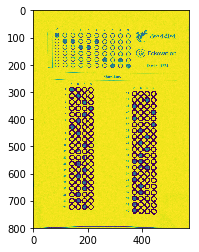

In [256]:
implt(questions)

In [257]:
ans_array=[]
ans_array=get_answers(questionCnts, thresh, ANSWER_KEY, ans_array)
print(ans_array)

0 0
1 4
2 8
3 12
4 16
5 20
6 24
7 28
8 32
9 36
10 40
11 44
12 48
13 52
14 56
15 60
16 64
17 68
18 72
19 76
20 80
21 84
22 88
23 92
24 96
25 100
26 104
27 108
28 112
29 116
30 120
31 124
32 128
33 132
34 136
35 140
36 144
37 148
38 152
39 156
[0, 'NA', 1, 2, 2, 0, 3, 3, 2, 0, 1, 3, 0, 1, 1, 2, 'NA', 1, 2, 2, 'NA', 1, 'NA', 'NA', 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 2, 0]


In [258]:
score = (correct / len(questionCnts)) * 100
print(correct)
print("[INFO] Score: {:.0f}%".format(score))
cv2.putText(paper, "{:.0f}%".format(score), (10, 30),
cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.imshow("Result", paper)
cv2.imwrite("Result.jpg", paper)
cv2.waitKey(10000)
cv2.destroyAllWindows()

0
[INFO] Score: 0%


In [ ]:
def write_to_csv(ans_array, filename):
    file=open(filename, "w+")
    for x in ans_array:
        file.write(str(x))
        file.write(',')
    file.close()    

In [ ]:
write_to_csv(ans_array, "abc.txt")